## Eigenface for face recognition

(b) Load the training set into a matrix X: there are 540 training images in total, each has 50 × 50 pixels that need to be concatenated into a 2500-dimensional vector. So the size of X should be 540 × 2500, where each row is a flattened face image. Pick a face image from X and display that image in grayscale. Do the same thing for the test set. The size of matrix Xtest for the test set should be 100 × 2500.

(540, 2500) (540,)


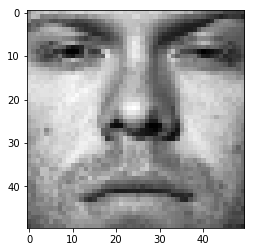

In [48]:
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm

%matplotlib inline
train_labels, train_data = [], []
for line in open('./faces/train.txt'):
    im = misc.imread(line.strip().split()[0])
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)
print(train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

(100, 2500)


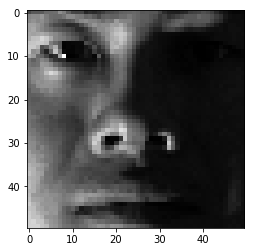

In [49]:
test_data = []
test_labels = []
for line in open('./faces/test.txt'):
    im = misc.imread(line.strip().split()[0])
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])
test_data = np.array(test_data, dtype=float)
test_labels = np.array(test_labels, dtype=float)
print(test_data.shape)
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

(c) Average Face. Compute the average face μ from the whole training set by summing up every column in X then dividing by the number of faces. Display the average face as a grayscale image.

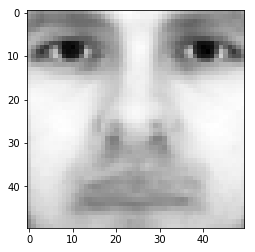

In [50]:
avg_face = train_data.mean(axis = 0)
plt.imshow(avg_face.reshape(50,50), cmap = cm.Greys_r)

(d) Mean Subtraction. Subtract average face μ from every column in X. That is, xi := xi − μ, where xi is the i-th column of X. Pick a face image after mean subtraction from the new X and display that image in grayscale. Do the same thing for the test set Xtest using the pre- computed average face μ in (c).

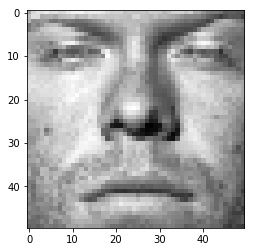

In [51]:
sd_train = (train_data - avg_face)
plt.imshow(sd_train[10, :].reshape(50,50), cmap = cm.Greys_r)

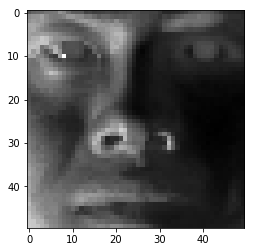

In [54]:
sd_test = (test_data - avg_face)
plt.imshow(sd_test[10, :].reshape(50,50), cmap = cm.Greys_r)

(e) Eigenface. Perform Singular Value Decomposition (SVD) on training set X (X = UΣVT ) to get matrix VT , where each row of VT has the same dimension as the face image. We refer to vi, the i -th row of VT , as i -th eigenface. Display the first 10 eigenfaces as 10 images in grayscale.

In [68]:
import numpy as np
U, d, Vt = np.linalg.svd(sd_train, full_matrices = False)
S = np.diag(d)

In [69]:
U.shape, S.shape, Vt.shape

((540, 540), (540, 540), (540, 2500))

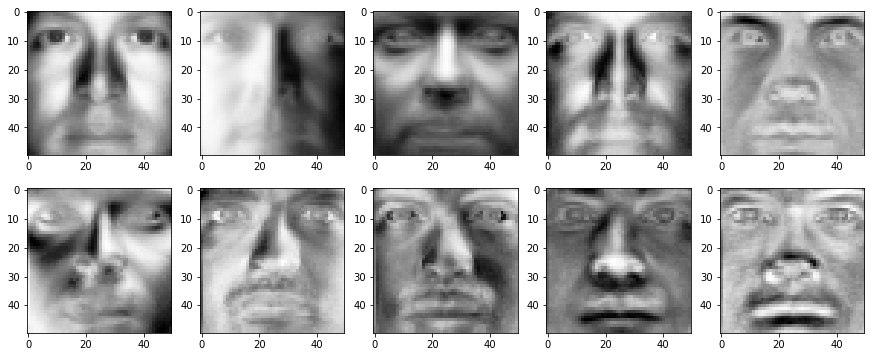

In [70]:
plt.figure(figsize = (15, 6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Vt[i, :].reshape(50,50), cmap = cm.Greys_r)

(f) Low-rank Approximation. Since Σ is a diagonal matrix with non-negative real numbers on the diagonal in non-ascending order, we can use the first r elements in Σ together with first r columns in U and first r rows in VT to approximate X. That is, we can approximate X by Xˆr = U[:,: r] Σ[: r,: r] VT [: r,:]. The matrix Xˆr is called rank-r approximation of X. Plot the rank-r approximationerror∥X−Xˆr∥F 2 asafunctionofr whenr =1,2,...,200.

In [71]:
def approx(U, S, Vt, r = 20):
    U = U[:, :r]
    S = S[:r, :r]
    Vt = Vt[:r, :]
    X = U.dot(S).dot(Vt)
    return X

In [72]:
error = []
X = train_data
rank = list(range(1,201))
for r in rank:
    X_a = approx(U, S, Vt, r = r)
    e = np.linalg.norm(X - X_a)
    error.append(e)

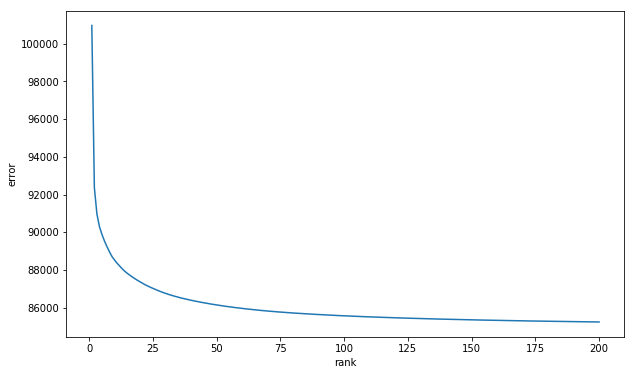

In [73]:
plt.figure(figsize = (10,6))
plt.plot(rank, error)
plt.xlabel('rank')
plt.ylabel('error')

(g) Eigenface Feature. The top r eigenfaces VT [: r,:] = {v1,v2,...,vr }T span an r-dimensional linear subspace of the original image space called face space, whose origin is the average face μ, and whose axes are the eigenfaces {v1,v2,...,vr}. Therefore, using the top r eigenfaces {v1,v2,...,vr},we can represent a 2500-dimensional face image z as an r-dimensional feature vector f: f = VT [: r,:] z = [v1,v2,...,vr ]T z. Write a function to generate r-dimensional feature matrix F and Ftest for training images X and test images Xtest, respectively (to get F, multiply X to the transpose of first r rows of VT , F should have same number of rows as X and r columns; similarly for Xtest).

In [74]:
def r_matrix(X, Vt, r):
    V = Vt[:r, :]
    V = V.T
    return X.dot(V)

F = r_matrix(train_data, Vt, r = 20)
F.shape

(540, 20)


(h) Face Recognition. Extract training and test features for r = 10. Train a Logistic Regression model using F and test on Ftest. Report the classification accuracy on the test set. Plot the classification accuracy on the test set as a function of r when r = 1,2,...,200. Use “one-vs- rest” logistic regression, where a classifier is trained for each possible output label. Each classifier is trained on faces with that label as positive data and all faces with other labels as negative data. sklearn calls this “ovr” mode.

In [80]:
F = r_matrix(sd_train, Vt, r = 10)
F_test = r_matrix(sd_test, Vt, r = 10)

In [81]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(F, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
lr.score(F_test, test_labels)

0.79000000000000004

In [86]:
accuracy = []
for r in rank:
    F = r_matrix(sd_train, Vt, r = r)
    F_test = r_matrix(sd_test, Vt, r = r)
    lr = LogisticRegression(multi_class='ovr')
    lr.fit(F, train_labels)
    score = lr.score(F_test, test_labels)
    accuracy.append(score)

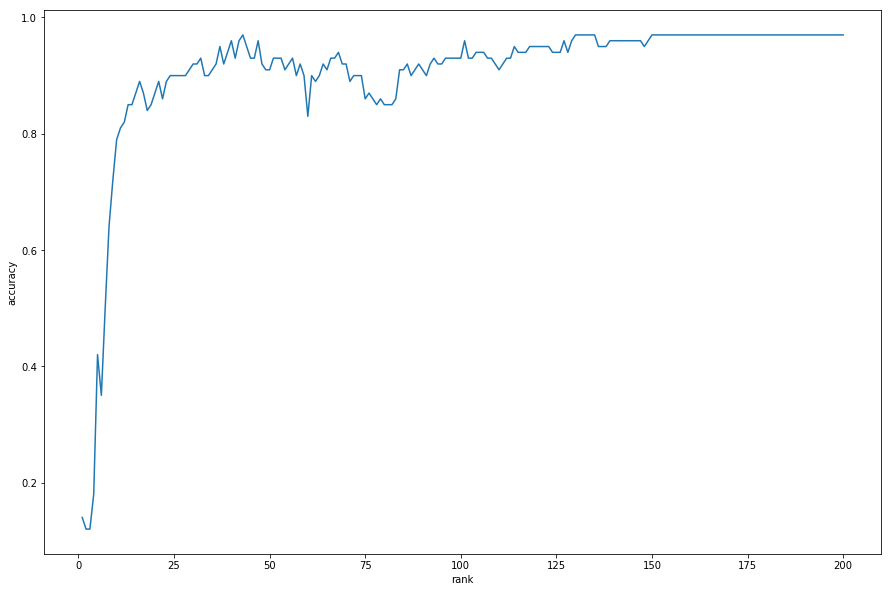

In [87]:
plt.figure(figsize = (15,10))
plt.plot(rank, accuracy)
plt.xlabel('rank')
plt.ylabel('accuracy')